<a href="https://colab.research.google.com/github/pranaya-mathur/Deep-Learning-Projects/blob/master/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras import regularizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [3]:
# reading datasets

project_data = pd.read_csv("drive/My Drive/Donors for AFR Classroom/train_data.csv")
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [4]:
project_data["project_is_approved"].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [5]:
resources = pd.read_csv("drive/My Drive/Donors for AFR Classroom/resources.csv")
resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [0]:
# We will combine these two datasets based on the id

price_data = resources.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [7]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 19 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

In [74]:
# It can been seen that there are some emtpy cells both for project_essay_3 and project_essay_4
# We will combine all the project essay columns into one single feature

project_data["text"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str) + \
                        project_data["project_title"].map(str)


KeyError: ignored

In [0]:
project_data = project_data.drop(["project_essay_1","project_essay_2","project_essay_3","project_essay_4"],axis=1)

In [73]:
project_data['essay'] = project_data['essay'].apply(lambda x: " ".join(x.lower() for x in x.split()))
project_data['essay'] = project_data['essay'].str.replace('[^\w\s]','')
project_data['essay'] = project_data['essay'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

KeyError: ignored

In [0]:
# We clean the essay text data
# For this task, we have defined some helper functions
# The same function and code snippet will be used to clean project title
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [11]:
# Cleaning Essay feature

preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:08<00:00, 1598.66it/s]


In [12]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent1 = decontracted(sentance)
    sent1 = sent1.replace('\\r', ' ')
    sent1 = sent1.replace('\\"', ' ')
    sent1 = sent1.replace('\\n', ' ')
    sent1 = re.sub('[^A-Za-z0-9]+', ' ', sent1)
    # https://gist.github.com/sebleier/554280
    sent1 = ' '.join(e for e in sent1.split() if e not in stopwords)
    preprocessed_title.append(sent1.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 34037.87it/s]


In [0]:
project_data["cleaned_essay"] = preprocessed_essays
project_data["cleaned_title"] = preprocessed_title
# Adding to essay text data + project title
project_data["text"] = project_data["cleaned_title"].map(str) + project_data["cleaned_essay"].map(str)

In [0]:
project_data = project_data.drop(["essay","cleaned_essay","cleaned_title","project_title","id","teacher_id","project_submitted_datetime",
                                  "Unnamed: 0"],axis=1)

In [15]:
project_data.shape

(109248, 11)

In [16]:
project_data["text"][:5]

0    educational support english learners homemy st...
1    wanted projector hungry learnersour students a...
2    soccer equipment awesome middle school student...
3    techie kindergartenersi work unique school fil...
4    interactive math toolsour second grade classro...
Name: text, dtype: object

In [0]:
# we have categorical features also, will do cleaning one by one

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()


project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()


project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()


project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

project_data['school_state'] = project_data['school_state'].str.lower()

In [18]:
project_data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,text
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,My students need opportunities to practice beg...,0,0,154.60,23,educational support english learners homemy st...
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,My students need a projector to help with view...,7,1,299.00,1,wanted projector hungry learnersour students a...
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,"My students need shine guards, athletic socks,...",1,0,516.85,22,soccer equipment awesome middle school student...
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,My students need to engage in Reading and Math...,4,1,232.90,4,techie kindergartenersi work unique school fil...
4,mrs,tx,grades_prek_2,math_science,mathematics,My students need hands on practice in mathemat...,1,1,67.98,4,interactive math toolsour second grade classro...


In [19]:
# we will extract numerical digits from the project resource summary

project_summary_numerical = []
for sentance in tqdm(project_data['project_resource_summary']):
    sent1 = decontracted(sentance)
    sent1 = ' '.join(e for e in sent1.split() if e.isdigit())
    k=len(sent1)
    project_summary_numerical.append(k)

project_data["project_summary_numerical"] = project_summary_numerical

100%|██████████| 109248/109248 [00:01<00:00, 67963.65it/s]


In [20]:
# downloading pretrained embeddings

!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2019-08-03 05:16:27--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2019-08-03 05:16:27--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2019-08-03 05:16:28--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [0]:
# duba nhi jara si shyam to hone do are main khud loot jaaunga mujhe nakam to hone do

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("glove.42B.300d.zip", 'r')
zip_ref.extractall("glove")
zip_ref.close()


In [22]:
project_data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,text,project_summary_numerical
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,My students need opportunities to practice beg...,0,0,154.60,23,educational support english learners homemy st...,0
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,My students need a projector to help with view...,7,1,299.00,1,wanted projector hungry learnersour students a...,0
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,"My students need shine guards, athletic socks,...",1,0,516.85,22,soccer equipment awesome middle school student...,0
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,My students need to engage in Reading and Math...,4,1,232.90,4,techie kindergartenersi work unique school fil...,0
4,mrs,tx,grades_prek_2,math_science,mathematics,My students need hands on practice in mathemat...,1,1,67.98,4,interactive math toolsour second grade classro...,0


In [0]:
target = project_data["project_is_approved"]
features = project_data.drop(["project_resource_summary","project_is_approved"],axis=1)

In [0]:
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, stratify=target,random_state=123)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train,random_state=123)

In [25]:
X_train.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,price,quantity,text,project_summary_numerical
19713,mrs,mi,grades_3_5,music_arts,music,2,39.99,15,ukuleles musical understandingas music teacher...,0
24882,mrs,ca,grades_3_5,literacy_language_math_science,literature_writing_mathematics,0,407.38,6,coffee shop collaboration classroommy students...,0
56171,ms,pa,grades_9_12,warmth_care_hunger,warmth_care_hunger,3,150.62,11,school uniforms neededthe students class membe...,0
28750,mrs,ga,grades_3_5,math_science,mathematics,0,383.08,1,please help make our classroom warm invitingmy...,0
59581,ms,tx,grades_prek_2,literacy_language_math_science,literacy_mathematics,3,325.00,1,fairy tale explorationmy students active explo...,0


In [26]:
print(X_train.shape)
print("+++++++++++++")
print(X_test.shape)
print("+++++++++++++")
print(X_cv.shape)

(69918, 10)
+++++++++++++
(21850, 10)
+++++++++++++
(17480, 10)


In [0]:
# Preparing Text Data for our Model

results = set()
project_data['text'].str.lower().str.split().apply(results.update)
print(len(results))

90391


In [0]:
MAX_SEQUENCE_LENGTH = 1500
MAX_VOCAB_SIZE = 100000
EMBEDDING_DIM = 300

In [28]:
word2vec = {}
with open("glove/glove.42B.300d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 1917494 word vectors.


In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train["text"])
sequences_train = tokenizer.texts_to_sequences(X_train["text"])
sequences_test = tokenizer.texts_to_sequences(X_test["text"])
sequences_cv = tokenizer.texts_to_sequences(X_cv["text"])

In [30]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 72363 unique tokens.


In [31]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (69918, 1500)


In [32]:
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (21850, 1500)


In [33]:
encoded_cv = pad_sequences(sequences_cv, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_cv.shape)

Shape of data tensor: (17480, 1500)


In [34]:
encoded_cv

array([[  268,    81,  1636, ...,     0,     0,     0],
       [ 3692,  2533,   917, ...,     0,     0,     0],
       [69471,  6799,    59, ...,     0,     0,     0],
       ...,
       [  429,   176,   408, ...,     0,     0,     0],
       [  145,   593,   759, ...,     0,     0,     0],
       [   11,    88,    10, ...,     0,     0,     0]], dtype=int32)

In [0]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [36]:
print(num_words)

72364


In [37]:
print(embedding_matrix.shape)

(72364, 300)


In [38]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,),name="input_text")
x = embedding_layer(input_text)
x = LSTM(64, return_sequences=True,dropout=0.3)(x)
flatten_1 = Flatten()(x)

W0803 05:33:43.418091 139901624346496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 05:33:43.503155 139901624346496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 05:33:43.528795 139901624346496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 05:33:43.552364 139901624346496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 05:33:43.553921 1399016243

In [39]:
X_train.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'text', 'project_summary_numerical'],
      dtype='object')

In [40]:
# Now will prepare all the remaining categorical features
# Teacher Prefix
no_of_unique_prefix  = X_train["teacher_prefix"].nunique()
embedding_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))
print('Unique Categories:', no_of_unique_prefix,'Embedding Size:', embedding_size_prefix)

Unique Categories: 5 Embedding Size: 3


In [0]:
# Defining Input and Embedding Layer for the same

input_prefix = Input(shape=(1,),name="teacher_prefix")
embedding_prefix = Embedding(no_of_unique_prefix,embedding_size_prefix,name="emb_pre",trainable=True)(input_prefix)
flatten_2 = Flatten()(embedding_prefix)

lb = LabelEncoder()
encoder_prefix_train = lb.fit_transform(X_train["teacher_prefix"])
encoder_prefix_cv = lb.transform(X_cv["teacher_prefix"])
encoder_prefix_test = lb.transform(X_test["teacher_prefix"])

In [44]:
print(encoder_prefix_train)
print(type(encoder_prefix_train))
print(encoder_prefix_train.shape)

[2 2 3 ... 2 3 3]
<class 'numpy.ndarray'>
(69918,)


In [45]:
# School State
no_of_unique_state  = X_train["school_state"].nunique()
embedding_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))
print('Unique Categories:', no_of_unique_state,'Embedding Size:', embedding_size_state)

Unique Categories: 51 Embedding Size: 26


In [0]:
# Defining Input and Embedding Layer for the same

input_state = Input(shape=(1,),name="school_prefix")
embedding_state = Embedding(no_of_unique_state,embedding_size_state,name="emb_state",trainable=True)(input_state)
flatten_3 = Flatten()(embedding_state)


encoder_state_train = lb.fit_transform(X_train["school_state"])
encoder_state_cv = lb.transform(X_cv["school_state"])
encoder_state_test = lb.transform(X_test["school_state"])

In [47]:
print(encoder_state_train.shape)

(69918,)


In [48]:
# For project_grade_category
no_of_unique_grade  = X_train["project_grade_category"].nunique()
embedding_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))
print('Unique Categories:', no_of_unique_grade,'Embedding Size:', embedding_size_grade)


Unique Categories: 4 Embedding Size: 2


In [0]:
# Defining Input and Embedding Layer for the same

input_grade= Input(shape=(1,),name="grade_cat")
embedding_grade = Embedding(no_of_unique_grade,embedding_size_grade,name="emb_grade",trainable=True)(input_grade)
flatten_4 = Flatten()(embedding_grade)


encoder_grade_train = lb.fit_transform(X_train["project_grade_category"])
encoder_grade_cv = lb.transform(X_cv["project_grade_category"])
encoder_grade_test = lb.transform(X_test["project_grade_category"])

In [50]:
print(encoder_grade_train.shape)

(69918,)


In [51]:
# For project_subject_categories
no_of_unique_subcat  = X_train["project_subject_categories"].nunique()
embedding_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat,'Embedding Size:', embedding_size_subcat)


Unique Categories: 51 Embedding Size: 26


In [0]:
# Defining Input and Embedding Layer for the same

input_subcat= Input(shape=(1,),name="sub_cat")
embedding_subcat = Embedding(no_of_unique_subcat,embedding_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flatten_5 = Flatten()(embedding_subcat)


encoder_subcat_train = lb.fit_transform(X_train["project_subject_categories"])
encoder_subcat_cv = lb.transform(X_cv["project_subject_categories"])
encoder_subcat_test = lb.transform(X_test["project_subject_categories"])

In [53]:
print(encoder_subcat_train.shape)

(69918,)


In [54]:
# For project_subject_subcategories
no_of_unique_subcat_1  = X_train["project_subject_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)


Unique Categories: 390 Embedding Size: 50


In [0]:
# Defining Input and Embedding Layer for the same

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flatten_6 = Flatten()(embedding_subcat_1)


# encoder_subcat_1_train = lb.fit_transform(X_train["project_subject_subcategories"])
# encoder_subcat_1_cv = lb.transform(X_cv["project_subject_subcategories"])
# encoder_subcat_1_test = lb.transform(X_test["project_subject_subcategories"])

In [0]:
le = LabelEncoder()
le.fit(X_train["project_subject_subcategories"])
X_test["project_subject_subcategories"] = X_test["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
X_cv["project_subject_subcategories"] = X_cv["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_1_train = le.transform(X_train["project_subject_subcategories"])
encoder_subcat_1_test= le.transform(X_test["project_subject_subcategories"])
encoder_subcat_1_cv = le.transform(X_cv["project_subject_subcategories"])

In [57]:
print(encoder_subcat_1_train.shape)

(69918,)


In [0]:
# Now we will prepare numerical features for our model
num_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
num_train_2=X_train['price'].values.reshape(-1, 1)
num_train_3=X_train['quantity'].values.reshape(-1, 1)
num_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
num_test_2=X_test['price'].values.reshape(-1, 1)
num_test_3=X_test['quantity'].values.reshape(-1, 1)
num_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_cv_1=X_cv['project_summary_numerical'].values.reshape(-1, 1)
num_cv_2=X_cv['price'].values.reshape(-1, 1)
num_cv_3=X_cv['quantity'].values.reshape(-1, 1)
num_cv_4=X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((num_train_1,num_train_2,num_train_3,num_train_4),axis=1)

num_test=np.concatenate((num_test_1,num_test_2,num_test_3,num_test_4),axis=1)

num_cv=np.concatenate((num_cv_1,num_cv_2,num_cv_3,num_cv_4),axis=1)


In [59]:
print(num_train.shape)

(69918, 4)


In [0]:
from sklearn.preprocessing import Normalizer
norm=Normalizer()
norm_train=norm.fit_transform(num_train)
norm_test=norm.transform(num_test)
norm_cv=norm.transform(num_cv)


In [0]:
# Defining the Input and Embedding Layer for the same

num_feats = Input(shape=(4,),name="numerical_features")
num_feats_ = Dense(64,activation="relu",kernel_initializer="he_normal")(num_feats)

In [62]:
print("Building Model-1")
x_concatenate = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,num_feats_])
x = Dense(64, activation='relu',kernel_initializer="he_normal")(x_concatenate)
x=Dropout(0.4)(x)
x = Dense(32, activation='relu',kernel_initializer="he_normal")(x)
x=Dropout(0.4)(x)
x = Dense(10, activation='relu',kernel_initializer="he_normal")(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_text,input_prefix,input_state,input_grade,
                        input_subcat,input_subcat_1,num_feats],outputs=[output])
# print(model_1.summary())

Building Model-1


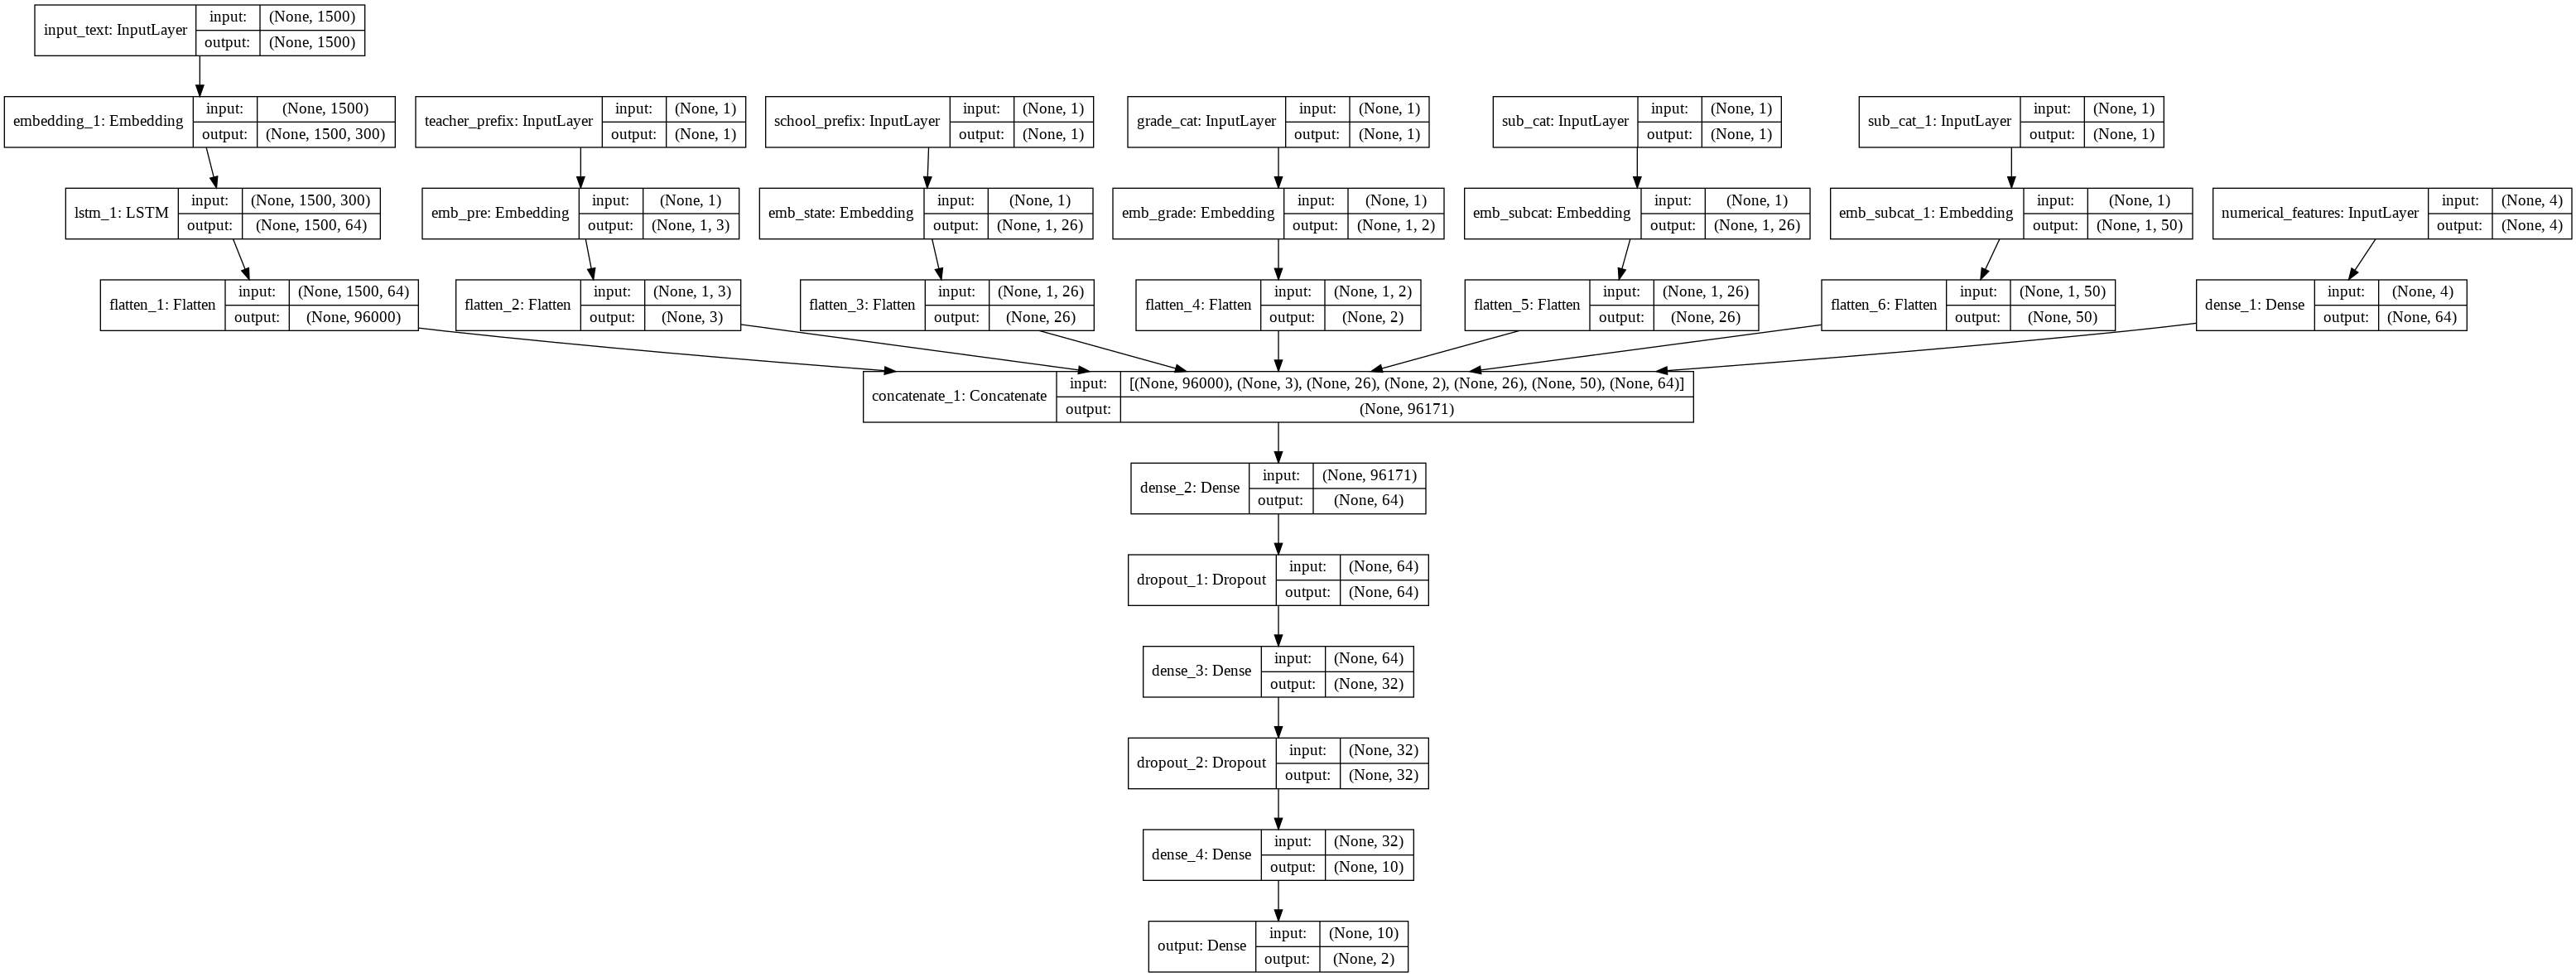

In [63]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(model_1, show_shapes=True, show_layer_names=True, to_file='model_1.png')
from IPython.display import Image
Image(retina=True, filename='model_1.png')

In [0]:
train_data_1 = [encoded_train,encoder_prefix_train,encoder_state_train,
              encoder_grade_train,encoder_subcat_train,encoder_subcat_1_train,norm_train]
test_data_1 = [encoded_test,encoder_prefix_test,encoder_state_test,encoder_grade_test,
             encoder_subcat_test,encoder_subcat_1_test,norm_test]
cv_data_1 = [encoded_cv,encoder_prefix_cv,encoder_state_cv,encoder_grade_cv,
           encoder_subcat_cv,encoder_subcat_1_cv,norm_cv]            

In [0]:
checkpoint_1 = ModelCheckpoint("model_1.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

earlystop_1 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

tensorboard_1 = TensorBoard(log_dir='graph_1', histogram_freq=0, batch_size=128, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_1 = [checkpoint_1,earlystop_1,tensorboard_1]

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

# def auc1(y_true, y_pred):
#     if len(np.unique(y_true[:,1])) == 1:
#         return 0.5
#     else:
#         return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
# clipvalue=(0.5)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
class_weight = {0: 10.,
                1: 1.
                }

In [0]:
model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

In [0]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)
Y_cv = np_utils.to_categorical(y_cv, 2)

In [70]:
history_1 = model_1.fit(train_data_1,Y_train,batch_size=512,
                        epochs=50,validation_data=(cv_data_1,Y_cv),callbacks=callbacks_1)

W0803 05:54:58.761317 139901624346496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W0803 05:55:01.280879 139901624346496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0803 05:55:01.282437 139901624346496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
69918/69918 [==============================] - 445s 6ms/step - loss: 0.5103 - auroc: 0.5093 - val_loss: 0.4274 - val_auroc: 0.5984

Epoch 00001: val_auroc improved from -inf to 0.59836, saving model to model_1.h5
Epoch 2/50
69918/69918 [==============================] - 444s 6ms/step - loss: 0.4571 - auroc: 0.5490 - val_loss: 0.4247 - val_auroc: 0.6773

Epoch 00002: val_auroc improved from 0.59836 to 0.67725, saving model to model_1.h5
Epoch 3/50
69918/69918 [==============================] - 444s 6ms/step - loss: 0.4359 - auroc: 0.6054 - val_loss: 0.4046 - val_auroc: 0.7028

Epoch 00003: val_auroc improved from 0.67725 to 0.70279, saving model to model_1.h5
Epoch 4/50
69918/69918 [==============================] - 443s 6ms/step - loss: 0.4237 - auroc: 0.6394 - val_loss: 0.3916 - val_auroc: 0.7151

Epoch 00004: val_auroc improved from 0.70279 to 0.71512, saving model to model_1.h5
Epoch 5/50
69918/69918 [==============================] - 442s 6ms/step - loss: 0.4161 - auroc:

In [0]:
from keras.models import load_model

my_model_1 = load_model("model_1.h5",custom_objects={"auroc":auroc})

Test Loss: 0.38346379765383987
Test ROC-AUC: 0.732121998490781


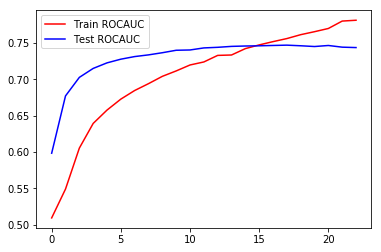

In [72]:
score_1 = my_model_1.evaluate(test_data_1, Y_test, verbose=0,batch_size=512) 
print('Test Loss:', score_1[0]) 
print('Test ROC-AUC:', score_1[1])

plt.plot(history_1.history['auroc'], 'r')
plt.plot(history_1.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()